## With Rotation

In [1]:
#Code checked: 09/27/2024, Dumi

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

import cuml
from cuml.svm import SVR as cuSVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score
import matplotlib.pyplot as plt

# Load the dataset from the specified file path
file_path = 'new_vega_rotation_overshooting_alpha_mlt_test_no_num_BIGGER_num_gt_180.csv'
data = pd.read_csv(file_path, delimiter=",", header=0)

# Display the column names of the dataset
data.columns


ModuleNotFoundError: No module named 'cuml'

In [2]:
# Sample 20,000 rows from the data for training and testing
data_sample = pd.DataFrame(data).sample(n=20000, random_state=43)

# Define the features (X) and the target variable (y)
x = data_sample[['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum']]
y = data_sample['log_k']

# Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler to standardize the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)  # Fit and transform the training set
X_test_scaled = scaler.transform(x_test)  # Only transform the testing set

# Build and train the Support Vector Regression model using cuML (GPU-accelerated SVR)
model = cuSVR(kernel='linear')
model.fit(X_train_scaled, y_train)  # Fit the model to the scaled training data


[W] [18:19:20.206676] SVR with the linear kernel can be much faster using the specialized solver provided by LinearSVR. Consider switching to LinearSVR if tranining takes too long.


SVR()

Text(0.5, 1.0, 'SVR: Actual vs Predicted Values')

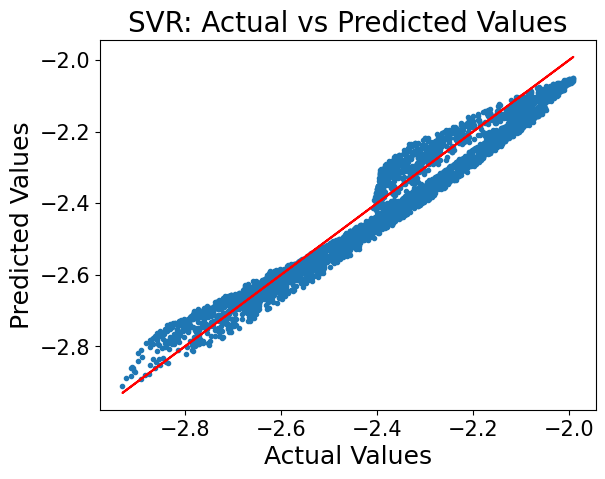

In [3]:
# Generate predictions using the trained SVR model
predictions = model.predict(X_test_scaled)

# Create a plot to visualize actual vs. predicted values
fig, ax = plt.subplots()

# Set labels and title for the plot
ax.set_xlabel(r"Actual Values", fontsize=18)
ax.set_ylabel(r"Predicted Values", fontsize=18)
ax.tick_params(axis='x', labelsize=15)  # Customize tick label size on x-axis
ax.tick_params(axis='y', labelsize=15)  # Customize tick label size on y-axis

# Plot the actual vs. predicted values as a scatter plot
ax.plot(y_test, predictions, ' .')  # ' .' creates a scatter plot with dots
ax.plot(y_test, y_test, color='r')  # Line representing perfect predictions (y = x), in red
ax.set_title('SVR: Actual vs Predicted Values', fontsize=20)  # Set title

# Show the plot
plt.show()


In [4]:
# Import evaluation metrics
from sklearn import metrics

# Calculate Mean Squared Error (MSE)
mse = metrics.mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R² Score (model accuracy)
r2 = metrics.r2_score(y_test, predictions)

# Calculate Mean Absolute Error (MAE) - lower values indicate better performance
mae = metrics.mean_absolute_error(y_test, predictions)

# Print performance metrics
print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.4f}')
print(f'Model Accuracy (R²): {r2 * 100:.2f}%')
print(f'Mean Absolute Error: {mae:.4f}')

MSE: 0.0030
RMSE: 0.0548
Model accuracy is 94.44%
Mean Absolute Error is 0.0487


## Feature Importance¶
#### Since SVR does not provide feature importances directly, one way to estimate the importance of features is by using permutation importance. This method works by shuffling each feature and seeing how the model's performance changes.

lum: 0.5103711098284548
age: 0.32182938775746683
teff: 0.1946894076759611
mass: 0.029851608813496466
z: 0.016656012359181148
fov: 0.0005883240930169564
mlt: 9.564463525268963e-06


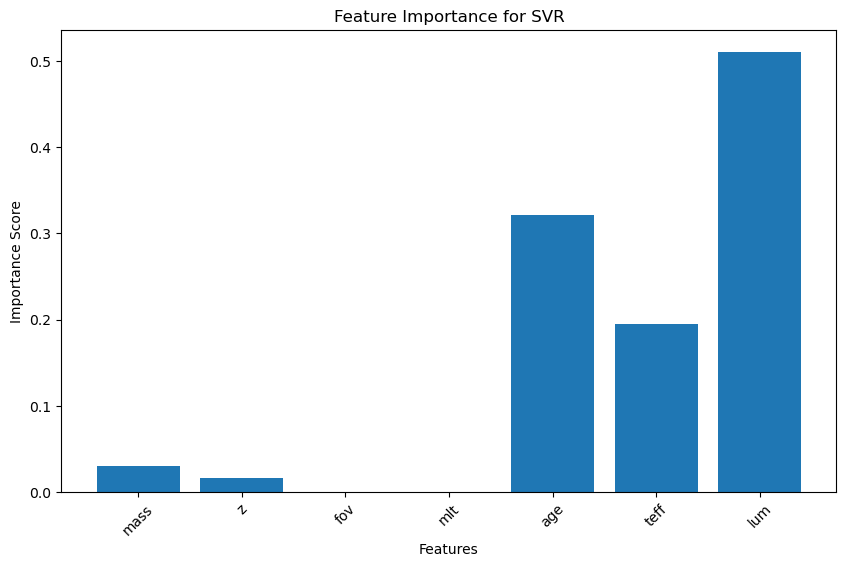

In [5]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importances
perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Extract the importances and sort them in descending order
importances = perm_importance.importances_mean
sorted_idx = perm_importance.importances_mean.argsort()  # Sorting by mean importance
features = ['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum']  # Feature names

# Print the feature importances in descending order
for idx in sorted_idx[::-1]:
    print(f"{features[idx]}: {perm_importance.importances_mean[idx]}")

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 6))
plt.bar(features, importances)  # Bar plot of the features and their importance scores
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance Score', fontsize=14)
plt.title('Feature Importance for SVR', fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotate feature names for better readability
plt.show()



## Recursive Feature Elimination

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

# Load dataset
file_path = 'new_vega_rotation_overshooting_alpha_mlt_test_no_num_BIGGER_num_gt_180.csv'
data = pd.read_csv(file_path, delimiter=",", header=0)

# Define features (X) and target (y)
x = data[['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum']]
y = data['log_k']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Sample 5000 data points for training and testing
x_train_sample = x_train.sample(n=5000, random_state=41).to_numpy()
x_test_sample = x_test.sample(n=5000, random_state=45).to_numpy()
y_train_sample = y_train.sample(n=5000, random_state=41).to_numpy()
y_test_sample = y_test.sample(n=5000, random_state=45).to_numpy()

# Build the Support Vector Regression model
model = SVR(kernel='linear')
model.fit(x_train_sample, y_train_sample)

# Initialize RFE (Recursive Feature Elimination) with the model
rfe = RFE(estimator=model, n_features_to_select=1)

# Fit RFE to the training data
rfe.fit(x_train_sample, y_train_sample)

# Get selected features based on RFE
selected_features = x.columns[rfe.support_]
print("Selected Features:", selected_features)

# Display the feature ranking (Rank #1 is the most important)
print("Feature Ranking:", rfe.ranking_)
 

/home/research2/miniconda3/envs/mlexp/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## SHAP

In [6]:
# Import libraries
!pip install shap
import shap

/home/research2/miniconda3/envs/rapids-24.08/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#===============================================================================
#X_train_sample=pd.DataFrame(x_train).sample(n=100, random_state=41).to_numpy()
#X_test_sample=pd.DataFrame(x_test).sample(n=100, random_state=45).to_numpy()
#===============================================================================

# Create a SHAP explainer
explainer = shap.Explainer(model.predict, X_train_scaled)

# Get SHAP values for a subset of the test set
shap_values = explainer(X_test_scaled)

# Plot feature importance bar chart
shap.summary_plot(shap_values, X_test_scaled, feature_names=['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum'])
shap.summary_plot(shap_values, X_test_scaled, feature_names=['mass', 'z', 'fov', 'mlt', 'age', 'teff', 'lum'], plot_type="bar")
